In [13]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121

###
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Distiller Class

In [8]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [15]:
# Define the distiller model by gpt
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1, temperature=3
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            ) * self.temperature**2

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        gradients = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
        return results

    def test_step(self, data):
        x, y = data
        student_predictions = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, student_predictions)
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = train_datagen_with_aug.flow_from_directory(
    r'/Users/hardikchhipa/Desktop/DR-Arvind/Aravind eye dataset/aptos2019-blindness-detection/train_split',
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='sparse',
    subset='training'
    ) # set as training data

validation_generator = train_datagen_with_aug.flow_from_directory(
    r'/Users/hardikchhipa/Desktop/DR-Arvind/Aravind eye dataset/aptos2019-blindness-detection/train_split', # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='sparse',
    subset='validation'
    ) # set as validation data

#input_img = Input(shape=(224, 224, 3))

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


Creating Teacher and Student Model

In [21]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models

# Load DenseNet-121 model without the top layers (pre-trained on ImageNet)
densenet121_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create the teacher model
teacher = models.Sequential([
    densenet121_model,                  # DenseNet base model
    layers.GlobalAveragePooling2D(),    # Reduces dimensionality (spatial pooling)
    layers.Dropout(0.2),                # Dropout to prevent overfitting
    layers.Dense(1024, activation='relu'), # Fully connected layer with ReLU activation
    layers.Dropout(0.2),                # Dropout
    layers.Dense(512, activation='relu'),  # Another dense layer with ReLU
    layers.Dense(5, activation='softmax')  # Final output layer (assuming 5 classes)
])

# Create the student model
student = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(16, (5, 5), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(48, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(128, (3, 3), strides=(1, 1), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
    layers.ReLU(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),

    layers.Flatten(),
    layers.Dense(600, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(150, activation='relu'),
    layers.Dense(5, activation='softmax')
])

student.summary()

# Clone the student model for scratch training comparison
student_scratch = models.clone_model(student)

# Image data generators
train_datagen_with_aug = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = train_datagen_with_aug.flow_from_directory(
    r'/Users/hardikchhipa/Desktop/DR-Arvind/Aravind eye dataset/aptos2019-blindness-detection/train_split',
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='sparse',
    subset='training'
    ) # set as training data

validation_generator = train_datagen_with_aug.flow_from_directory(
    r'/Users/hardikchhipa/Desktop/DR-Arvind/Aravind eye dataset/aptos2019-blindness-detection/train_split', # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    # color_mode='grayscale',
    class_mode='sparse',
    subset='validation'
    ) # set as validation data

#input_img = Input(shape=(224, 224, 3))

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 112, 112, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 7, 7, 48)       │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 7, 7, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 2, 2, 64)       │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 1, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 1, 1, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 600)            │        39,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 300)            │       180,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 150)            │        45,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 5)              │           755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 460,293 (1.76 MB)

 Trainable params: 460,293 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


Train the Teacher Network and Distill the Teacher weights to Student

In [22]:
 #Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=6,
)

# Distill teacher to student
graph=distiller.fit(train_generator, epochs=25, validation_data = validation_generator)
graph

# Evaluate student on test dataset
#distiller.evaluate(train_generator, epochs=15, validation_data = validation_generator)

Epoch 1/25


/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:582: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-09-06 11:25:18.589927:

92/92 ━━━━━━━━━━━━━━━━━━━━ 452s 5s/step - sparse_categorical_accuracy: 0.4276 - distillation_loss: 0.0120 - loss: 0.2000 - student_loss: 1.3162 - val_sparse_categorical_accuracy: 0.6101 - val_loss: 0.2000 - val_student_loss: 1.1792
Epoch 2/25


2024-09-06 11:32:42.900999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 11:32:54.845698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 386s 4s/step - sparse_categorical_accuracy: 0.6235 - distillation_loss: 0.0195 - loss: 0.2000 - student_loss: 1.0712 - val_sparse_categorical_accuracy: 0.6785 - val_loss: 0.2000 - val_student_loss: 0.9023
Epoch 3/25


2024-09-06 11:39:09.072706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 11:39:20.331216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 1298s 14s/step - sparse_categorical_accuracy: 0.6963 - distillation_loss: 0.0217 - loss: 0.2000 - student_loss: 0.9817 - val_sparse_categorical_accuracy: 0.7045 - val_loss: 0.2000 - val_student_loss: 1.0196
Epoch 4/25


2024-09-06 12:01:22.402236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-09-06 12:06:35.219420: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-06 12:06:38.023707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 19436s 210s/step - sparse_categorical_accuracy: 0.7085 - distillation_loss: 0.0218 - loss: 0.2000 - student_loss: 0.9509 - val_sparse_categorical_accuracy: 0.7086 - val_loss: 0.2000 - val_student_loss: 1.1118
Epoch 5/25


2024-09-06 17:24:44.822041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 17:24:55.804520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 444s 5s/step - sparse_categorical_accuracy: 0.7025 - distillation_loss: 0.0221 - loss: 0.2000 - student_loss: 0.9512 - val_sparse_categorical_accuracy: 0.7100 - val_loss: 0.2000 - val_student_loss: 0.9578
Epoch 6/25


2024-09-06 17:32:07.480525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 17:32:19.217185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 459s 5s/step - sparse_categorical_accuracy: 0.7015 - distillation_loss: 0.0223 - loss: 0.2000 - student_loss: 0.9387 - val_sparse_categorical_accuracy: 0.7059 - val_loss: 0.2000 - val_student_loss: 0.8448
Epoch 7/25


2024-09-06 17:39:45.838921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 17:39:57.046938: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 422s 4s/step - sparse_categorical_accuracy: 0.7043 - distillation_loss: 0.0228 - loss: 0.2000 - student_loss: 0.9425 - val_sparse_categorical_accuracy: 0.7100 - val_loss: 0.2000 - val_student_loss: 0.8105
Epoch 8/25


2024-09-06 17:46:48.821651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 17:47:00.066689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 398s 4s/step - sparse_categorical_accuracy: 0.7136 - distillation_loss: 0.0221 - loss: 0.2000 - student_loss: 0.9441 - val_sparse_categorical_accuracy: 0.7086 - val_loss: 0.2000 - val_student_loss: 0.8168
Epoch 9/25


2024-09-06 17:53:27.822756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 17:53:42.850633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 474s 5s/step - sparse_categorical_accuracy: 0.7125 - distillation_loss: 0.0227 - loss: 0.2000 - student_loss: 0.9346 - val_sparse_categorical_accuracy: 0.6990 - val_loss: 0.2000 - val_student_loss: 1.0727
Epoch 10/25


2024-09-06 18:01:21.109756: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 18:01:32.180676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/step - sparse_categorical_accuracy: 0.7144 - distillation_loss: 0.0223 - loss: 0.2000 - student_loss: 0.9315 - val_sparse_categorical_accuracy: 0.7100 - val_loss: 0.2000 - val_student_loss: 0.7349
Epoch 11/25


2024-09-06 18:08:33.411880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 18:08:44.698013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 510s 5s/step - sparse_categorical_accuracy: 0.7142 - distillation_loss: 0.0226 - loss: 0.2000 - student_loss: 0.9321 - val_sparse_categorical_accuracy: 0.7168 - val_loss: 0.2000 - val_student_loss: 0.8116
Epoch 12/25


2024-09-06 18:17:02.661251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 18:17:16.313349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 460s 5s/step - sparse_categorical_accuracy: 0.7242 - distillation_loss: 0.0235 - loss: 0.2000 - student_loss: 0.9191 - val_sparse_categorical_accuracy: 0.7196 - val_loss: 0.2000 - val_student_loss: 1.0058
Epoch 13/25


2024-09-06 18:24:42.593326: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 18:24:54.897903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 490s 5s/step - sparse_categorical_accuracy: 0.7275 - distillation_loss: 0.0224 - loss: 0.2000 - student_loss: 0.9282 - val_sparse_categorical_accuracy: 0.7114 - val_loss: 0.2000 - val_student_loss: 1.0752
Epoch 14/25


2024-09-06 18:32:55.103493: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 18:33:07.525487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 494s 5s/step - sparse_categorical_accuracy: 0.7265 - distillation_loss: 0.0227 - loss: 0.2000 - student_loss: 0.9256 - val_sparse_categorical_accuracy: 0.7141 - val_loss: 0.2000 - val_student_loss: 0.7867
Epoch 15/25


2024-09-06 18:41:06.480116: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 18:41:17.729337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 452s 5s/step - sparse_categorical_accuracy: 0.7183 - distillation_loss: 0.0227 - loss: 0.2000 - student_loss: 0.9230 - val_sparse_categorical_accuracy: 0.7100 - val_loss: 0.2000 - val_student_loss: 0.9827
Epoch 16/25


2024-09-06 18:48:38.751043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 18:48:49.859339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 433s 4s/step - sparse_categorical_accuracy: 0.7151 - distillation_loss: 0.0227 - loss: 0.2000 - student_loss: 0.9250 - val_sparse_categorical_accuracy: 0.7114 - val_loss: 0.2000 - val_student_loss: 0.9101
Epoch 17/25


2024-09-06 18:55:51.966901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 18:56:03.436719: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 412s 4s/step - sparse_categorical_accuracy: 0.7217 - distillation_loss: 0.0233 - loss: 0.2000 - student_loss: 0.9089 - val_sparse_categorical_accuracy: 0.7100 - val_loss: 0.2000 - val_student_loss: 0.7741
Epoch 18/25


2024-09-06 19:02:44.892500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 19:02:56.903090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 422s 4s/step - sparse_categorical_accuracy: 0.7166 - distillation_loss: 0.0236 - loss: 0.2000 - student_loss: 0.8988 - val_sparse_categorical_accuracy: 0.7209 - val_loss: 0.2000 - val_student_loss: 0.7331
Epoch 19/25


2024-09-06 19:09:45.803662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 19:09:57.540599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 426s 4s/step - sparse_categorical_accuracy: 0.7127 - distillation_loss: 0.0234 - loss: 0.2000 - student_loss: 0.9051 - val_sparse_categorical_accuracy: 0.7155 - val_loss: 0.2000 - val_student_loss: 0.6663
Epoch 20/25


2024-09-06 19:16:51.858526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 19:17:03.217248: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 433s 4s/step - sparse_categorical_accuracy: 0.7256 - distillation_loss: 0.0232 - loss: 0.2000 - student_loss: 0.9091 - val_sparse_categorical_accuracy: 0.7073 - val_loss: 0.2000 - val_student_loss: 0.9512
Epoch 21/25


2024-09-06 19:24:04.049186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 19:24:14.122487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-09-06 19:24:16.574647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 408s 4s/step - sparse_categorical_accuracy: 0.7235 - distillation_loss: 0.0230 - loss: 0.2000 - student_loss: 0.9073 - val_sparse_categorical_accuracy: 0.7155 - val_loss: 0.2000 - val_student_loss: 0.9072
Epoch 22/25


2024-09-06 19:30:52.875796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 19:31:03.596372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 388s 4s/step - sparse_categorical_accuracy: 0.7216 - distillation_loss: 0.0238 - loss: 0.2000 - student_loss: 0.8948 - val_sparse_categorical_accuracy: 0.7223 - val_loss: 0.2000 - val_student_loss: 0.8708
Epoch 23/25


2024-09-06 19:37:20.856934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 19:37:32.488789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 392s 4s/step - sparse_categorical_accuracy: 0.7355 - distillation_loss: 0.0235 - loss: 0.2000 - student_loss: 0.8937 - val_sparse_categorical_accuracy: 0.7168 - val_loss: 0.2000 - val_student_loss: 0.8788
Epoch 24/25


2024-09-06 19:43:53.303657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 19:44:04.979855: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 404s 4s/step - sparse_categorical_accuracy: 0.7291 - distillation_loss: 0.0240 - loss: 0.2000 - student_loss: 0.8899 - val_sparse_categorical_accuracy: 0.7141 - val_loss: 0.2000 - val_student_loss: 0.9203
Epoch 25/25


2024-09-06 19:50:37.615929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 4 of 8
2024-09-06 19:50:49.392442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


92/92 ━━━━━━━━━━━━━━━━━━━━ 395s 4s/step - sparse_categorical_accuracy: 0.7167 - distillation_loss: 0.0238 - loss: 0.2000 - student_loss: 0.8883 - val_sparse_categorical_accuracy: 0.6813 - val_loss: 0.2000 - val_student_loss: 1.0184


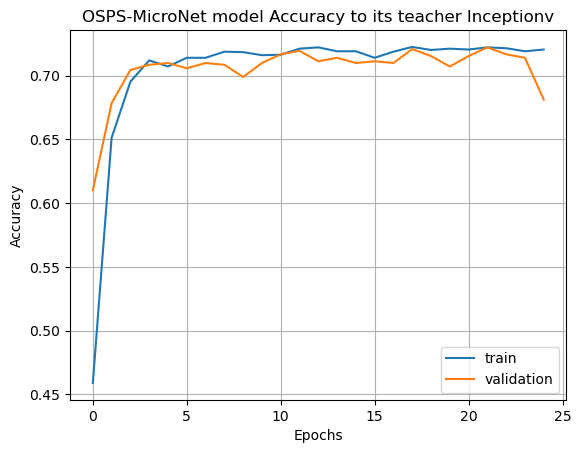

In [23]:
import matplotlib.pyplot as plt

fig1 = plt.gcf()

plt.plot(graph.history['sparse_categorical_accuracy'])
plt.plot(graph.history['val_sparse_categorical_accuracy'])

# plt.axis(ymin=0.4, ymax=1)
plt.grid()

plt.title('OSPS-MicroNet model Accuracy to its teacher Inceptionv')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])

plt.show()

In [24]:
max_acc = max(graph.history['val_sparse_categorical_accuracy'])
print('The highest accuracy achieved for OSPS-MicroNet model Accuracy to its teacher Densenet121 model is',max_acc*100)

The highest accuracy achieved for OSPS-MicroNet model Accuracy to its teacher Densenet121 model is 72.22982048988342
